In [1]:
"""
Sources:

2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

https://www.bloomberg.com/graphics/world-economic-indicators-dashboard/?leadSource=uverify%20wall

- Hierarchical TS: https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts

-Read this after workout: https://www.kaggle.com/code/gargaar/time-series-with-python


Credit: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from dateutil.relativedelta import relativedelta
from dateutil import relativedelta
from sklearn.model_selection import (
    train_test_split, 
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from dateutil.relativedelta import relativedelta
import datetime
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb



In [2]:
"""
Notes:
-------------------------------------------------------------------------------------------------------------------
Hyper-paramter Tuning
    Conversion of local minimum or maximum:
    1. Grid Search - goes through all but is slow
    2. Random Search - might not find all the hyper-parameters 
    3. Bayesian Search

-------------------------------------------------------------------------------------------------------------------
Cross-Validation
    -Technique for evaluating the performance of a machine learning model. 
     It helps to reduce overfitting by rotating the training dataset into different 
     training and validation sets and training the model on each subset.

    - There are several types of cross-validation, but the most common is k-fold cross-validation. 
     In k-fold cross-validation, the original dataset is partitioned into k smaller subsets, and the 
     model is trained and evaluated k times, with a different subset being used as the validation set in 
     each iteration. The performance measure is averaged over all k iterations, and the result is a 
     better estimate of the model's performance on unseen data.
     
     - Cross-validation helps to reduce the risk of overfitting by rotating the training data into different 
       training and validation sets and training the model on each subset. This allows you to obtain a better 
       estimate of the model's performance on unseen data.

-------------------------------------------------------------------------------------------------------------------
Regularization
    - The process of adding constraints to the model to prevent overfitting and improve generalization to unseen data.
    
    - There are different ways to regularize a model, such as:

        1. L1 regularization: This adds a penalty term to the objective function that is proportional to the absolute value of the model weights. 
           This results in a model with sparse weights, where some weights are exactly equal to zero.

        2. L2 regularization: This adds a penalty term to the objective function that is proportional to the square of the model weights. This 
           results in a model with small, non-zero weights.

        3. Early stopping: This involves training the model until the validation error starts to increase, and then stopping the training process. 
           This can help to prevent overfitting by limiting the number of iterations the model is trained for.

        4. Dropout: This involves randomly setting a fraction of the model weights to zero during training. This can help to prevent overfitting 
           by ensuring that the model does not rely too heavily on any single weight.

        By regularizing a model, you can often improve its generalization performance and reduce the risk of overfitting. 
        It is generally a good idea to regularize a model when the training data is limited or the model is prone to overfitting.


-------------------------------------------------------------------------------------------------------------------
MISC

        The max_depth hyperparameter is not directly related to regularization. max_depth controls the maximum depth of the trees in a random forest model, which determines how complex the model can be.

        Increasing the max_depth can make the model more complex and allow it to capture more intricate patterns in the data. However, a too-deep tree can lead to overfitting, as the model may be too specific to the training data and may not generalize well to unseen data.

        Therefore, the max_depth hyperparameter can be used to control the complexity of the model and prevent overfitting, but it is not considered a direct form of regularization like L1 or L2 regularization.

        It is generally a good idea to tune the max_depth hyperparameter along with other hyperparameters, such as the number of trees in the forest (n_estimators), to find the optimal model complexity and prevent overfitting. 
        You can use techniques such as cross-validation and grid search to find the optimal values for these hyperparameters.


"""

"\nNotes:\n-------------------------------------------------------------------------------------------------------------------\nHyper-paramter Tuning\n    Conversion of local minimum or maximum:\n    1. Grid Search - goes through all but is slow\n    2. Random Search - might not find all the hyper-parameters \n    3. Bayesian Search\n\n-------------------------------------------------------------------------------------------------------------------\nCross-Validation\n    -Technique for evaluating the performance of a machine learning model. \n     It helps to reduce overfitting by rotating the training dataset into different \n     training and validation sets and training the model on each subset.\n\n    - There are several types of cross-validation, but the most common is k-fold cross-validation. \n     In k-fold cross-validation, the original dataset is partitioned into k smaller subsets, and the \n     model is trained and evaluated k times, with a different subset being used as t

In [3]:
def first_day_of_month(date):
    """
    Sets all dates to first day of the month
    
    :param date: date object
    
    :return: date object with day replaced with one
    """
    year = date.year
    month = date.month
    return pd.datetime(year, month, 1)

def add_lags(df, num_lags, feature_lag_lst):
    """
    
    :param df: data frame to add lags to
    :param num_lags: # of lags
    :param feature_lag_lst: features to add lags to
    
    :return df, lag_lst: data frame with lags and list of lags
    """
    df = df.copy()
    lag_lst = []
    if num_lags:
        for feature in feature_lag_lst:
            target_map = df[feature].to_dict()
            for lag in range(1, num_lags):
                df[f'{feature}_lag_{lag}'] = (df.index - pd.DateOffset(months=lag)).map(target_map)
                lag_lst.append(f'{feature}_lag_{lag}')
        
    # df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364
    # df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # 728
    # df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # 1092
    return df, lag_lst

def generate_lagged_features_lst(lagged_attr, num_lags):
    """
    Generates a lagged feature list
    TODO: lag_lst from above can probably replace this
    
    :param lagged_attr: attributes to add the "lag_#" tag
    :param num_lags: number of lags
    
    :return features: list of features with the "lag_#" tag
    """
    
    features = []
    for attr in lagged_attr:
        for i in range(1,num_lags):
            features.append(f"{attr}_lag_{i}")
    return features

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df

In [4]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [5]:
def preprocess(df):
    df = df.copy()
    df.columns = [signal.lower().replace(" ", "_") for signal in df.columns] # upper to lower and replace space with underscores
    df['date'] = pd.to_datetime(df['date']) # To date-time object conversion
    df = df.resample('M', on='date').last() # Up-sample
    df.index = df.index.map(first_day_of_month) # Set index
    return df

In [6]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    # Create Lags
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['close'].shift(-i)
        i = i + 1
    
    # Create Steps
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['close'].shift(-output_length-j)
        j = j + 1
        
    # Drop all NaNs
    df = df.dropna(axis=0)
    
    return df

In [7]:
def create_lags(num_lags: int, feature_lst: list, data: pd.DataFrame, dropnan: bool) -> pd.DataFrame:
    """
    Create lagged features/target values from previous periods. At the moment, this function
    does this on a monthly level
    """
    df = data.copy()
    
    # Create Lags
    i = 1
    while i < num_lags:
        for feature in feature_lst:
            lagged_feature = f"x_lag_{feature}_{i}"
            df[lagged_feature] = df[f"{feature}"].shift(i) # Added lagged feature
        i = i + 1
    
    if dropnan: 
        df = df.dropna(axis = 0)
        
    return df

In [8]:
def create_steps(num_steps: int, target_lst: list, data: pd.DataFrame, dropnan: bool) -> pd.DataFrame:
    """
    Create steps into the future that you're trying to forecast
    """
    df = data.copy()
    
    # Create Steps
    i = 0
    while i < num_steps:
        for target in target_lst:
            step = f"y_step_{target}_{i}"
            df[step] = df[f"{target}"].shift(-num_steps-i) # Added Steps
        i = i + 1
    
    if dropnan: 
        df = df.dropna(axis = 0)
        
    return df

In [24]:
def cat_val_in_arr(data: list, categories: list) -> dict: 
    """
    Function that categorizes data in a given array based on number of total categories
    and stores resultant data in a dictionary of categorized arrays
    
    ex: 
        data = [1, 3, 5, 6, 4, 8, 3, 9, 11, ...]
    
                 idx |1. 2. 3. ...|
        categories = [a, b, c, ...]
        
        - There are three total categories. Every 3rd value in array starting
          and including zeroeth index value will be extracted
    
        - data will be split into as follow:
        - a_arr = [1, 6, 3]
        - b_arr = [3, 4, 9]
        - c_arr = [5, 8, 11]
    
    :param dataay: array to split
    :param categories: distinct array to split main data
    
    :return res: final output with values categorized and stored in a dictonary of n*category arrays
    """
    
    len_data = len(data)
    len_cat = len(categories)
    res = {} # store results in here
    
    cat_idx = 0 # init category index
    while cat_idx < len_cat: # Iterate through all categories
        # Assign category index to data index. 
        # This is the starting index for the data extraction step
        data_idx = cat_idx
        res[categories[cat_idx]] = [] # init dict to store data sorted into categories
        
        # Extract and sort data into its' category 
        # This is where we are extracting every nth data starting from index derived in above step
        while data_idx < len_data: 
            res[categories[cat_idx]].append(data[data_idx]) # Store value in categorical array
            data_idx += len_cat # Increment to next value
            
        cat_idx += 1 # Increment to next category 
            
    return res

In [25]:
qqq_df = pd.read_csv("QQQ.csv")
nvda_df = pd.read_csv("NVDA.csv")
spy_df = pd.read_csv("SPY.csv")
vti_df = pd.read_csv("VTI.csv")


qqq_df = preprocess(qqq_df)
nvda_df = preprocess(nvda_df)
spy_df = preprocess(spy_df)
vti_df = preprocess(vti_df)


df = spy_df.copy()
df["qqq_close"] = qqq_df["close"]
df["spy_close"] = spy_df["close"]
df["vti_close"] = vti_df["close"]

df.head(20)

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


,date,open,high,low,close,adj_close,volume,qqq_close,spy_close,vti_close
date,,,,,,,,,,
2000-01-01,2000-01-31,135.812500,139.671875,135.000000,139.562500,91.458748,10768700,89.687500,139.562500,NaN
2000-02-01,2000-02-29,136.062500,137.437500,135.750000,137.437500,90.066216,8242500,106.750000,137.437500,NaN
2000-03-01,2000-03-31,149.625000,152.312500,148.437500,150.375000,98.794930,9249100,109.500000,150.375000,NaN
2000-04-01,2000-04-28,147.000000,147.859375,145.062500,145.093750,95.325226,8743400,94.750000,145.093750,NaN
2000-05-01,2000-05-31,142.562500,144.000000,142.093750,142.812500,93.826439,6056500,83.125000,142.812500,NaN
2000-06-01,2000-06-30,143.937500,145.593750,143.890625,145.281250,95.673080,7420200,93.437500,145.281250,NaN
2000-07-01,2000-07-31,142.937500,144.125000,142.062500,143.000000,94.170860,5265500,89.437500,143.000000,NaN
2000-08-01,2000-08-31,151.062500,153.093750,150.906250,152.343750,100.324036,4863100,101.625000,152.343750,NaN
2000-09-01,2000-09-29,145.468750,145.968750,143.625000,143.625000,94.820030,9333600,88.750000,143.625000,NaN


In [26]:
"""
Preparation of all data

"""
FORECAST_HORIZONS = 18
back_test = True

if back_test:
    test_date = df.index.max() - relativedelta(months=FORECAST_HORIZONS)
    test_df = df[df.index > test_date].copy()
    df = df[df.index <= test_date].copy()


TARGET = ["close", "volume"]
FEATURES = ["close", "volume", "qqq_close"]
STEPS = FORECAST_HORIZONS
LAGS = 13
forecast_start_date = df.index.max() + relativedelta(months=1) # datetime.datetime(2020, 5, 17)

df = df[FEATURES]
lagged_df = create_lags(LAGS, TARGET, df, True)
stepped_df = create_steps(STEPS, TARGET, df, True)
# Drop target from one data frame and combine since both data frames contain 
seq_df = pd.merge(lagged_df.drop(columns = TARGET), stepped_df, left_index=True, right_index=True)

X_cols = [col for col in seq_df.columns if col.startswith('x')] # Derive list of features

for idx, val in enumerate(TARGET): # Add in targets into feature list
    X_cols.insert(0, val)
    
y_cols = [col for col in seq_df.columns if col.startswith('y')] # Derive list of outputs

# Filter training data
X_train = seq_df[X_cols].values
y_train = seq_df[y_cols].values

"""
Prepare Data frame to hold forecast results
"""
forecast_date_lst = pd.date_range(forecast_start_date, periods=STEPS, freq = 'M')
forecast_df = pd.DataFrame()
forecast_df['index'] = forecast_date_lst.values
forecast_df['index'] = pd.to_datetime(forecast_df['index']).map(first_day_of_month) 
forecast_df = forecast_df.set_index('index')

#Save Ground Truth in data frame
if back_test:
    short_name = "actuals"
    for target_idx, target_name in enumerate(TARGET):
        forecast_df[f"{short_name}_{target_name.lower()}"] = test_df[target_name] 

"""
Prepare inputs to feed into forecast
"""
forecast_inputs = create_lags(LAGS, TARGET, df, False)[X_cols][-1:] # Derive latest features to feed as forecast input


/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


In [28]:
"""
Time-series Split
Note: using X_cols instead of FEATURES as X_cols contains lagged features
"""
tss_enable = False
if tss_enable:
    tss = TimeSeriesSplit(n_splits=5, test_size=12*2, gap=0)

    fold = 0
    preds = []
    scores = []
    for train_idx, val_idx in tss.split(seq_df):
        train = seq_df.iloc[train_idx]
        test = seq_df.iloc[val_idx]

        X_train, X_test = train[X_cols], test[X_cols]
        y_train, y_test = train[TARGET], test[TARGET]

        dt_seq = DecisionTreeRegressor(random_state=42)
        dt_seq.fit(X_train, y_train)

        y_pred = dt_seq.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

    print(f'Score across folds {np.mean(scores):0.4f}')
    print(f'Fold scores:{scores}')

    """
    # Testing
    dt_seq = DecisionTreeRegressor(random_state=42)

    scores = cross_val_score(dt_seq, X_train, y_train, cv=5)
    print("Mean:", np.mean(scores))
    print("Standard Deviation:", np.std(scores))
    """

In [29]:
"""
Model Training w/ Decision Tree Regressor
"""
from sklearn.tree import DecisionTreeRegressor

# Config
hyper_param_tune_flg = False # Turned off because forecasts look worse with hyperparameter tuning. Revisit this...
short_name = "dt"
# Define the parameter grid for tuning
param_grid = {'max_depth': [2, 4, 6, 8],
              'min_samples_leaf': [2, 4, 6, 8],
              'max_features': ['auto', 'sqrt', 'log2']}



dt_seq = DecisionTreeRegressor(random_state=42)

if hyper_param_tune_flg:
    # Create an instance of GridSearchCV
    grid_search = GridSearchCV(dt_seq, param_grid, cv=5, scoring='neg_mean_squared_error')
    # Fit the GridSearchCV instance to the data
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and the best score
    best_params = grid_search.best_params_
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    
    # Create a new DecisionTreeRegressor using the best hyperparameters
    dt_seq = DecisionTreeRegressor(**best_params)
    
    # Retrain model with data
    dt_seq.fit(X_train, y_train)
    
else: 
    dt_seq.fit(X_train, y_train) # w/o grid_search


"""
Run Forecasts
"""

dt_seq_res = dt_seq.predict(forecast_inputs)

"""
Store Results
"""

# Store results in series
#forecast_series = pd.Series(data = dt_seq_res[0], index = forecast_df.index) # *** maybe don't need this

"""
If multi-variate forecast, take individual results out of single numpy array
and store forecast results in lists dedicated to the target. 
"""
forecast_dict = cat_val_in_arr(dt_seq_res[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [243]:
"""
Feature Importance
"""
# Create a list of tuples (column name, feature importance)
feature_importances = list(zip(seq_df[X_cols].columns, dt_seq.feature_importances_))
# Sort the list of tuples by feature importance
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
# Print the column name and feature importance
for feature in feature_importances:
    print(f'{feature[0]}: {feature[1]:.4f}')


x_lag_volume_6: 0.1810
x_lag_close_4: 0.1631
x_lag_volume_9: 0.0877
x_lag_close_12: 0.0794
x_lag_volume_3: 0.0494
x_lag_close_7: 0.0373
x_lag_close_5: 0.0368
x_lag_close_2: 0.0361
x_lag_close_11: 0.0318
x_lag_close_1: 0.0300
x_lag_close_6: 0.0277
volume: 0.0265
x_lag_close_3: 0.0257
close: 0.0255
x_lag_volume_10: 0.0244
x_lag_close_8: 0.0228
x_lag_volume_4: 0.0225
x_lag_volume_12: 0.0206
x_lag_volume_1: 0.0165
x_lag_volume_2: 0.0146
x_lag_volume_11: 0.0138
x_lag_close_9: 0.0096
x_lag_volume_7: 0.0085
x_lag_volume_8: 0.0059
x_lag_close_10: 0.0015
x_lag_volume_5: 0.0011


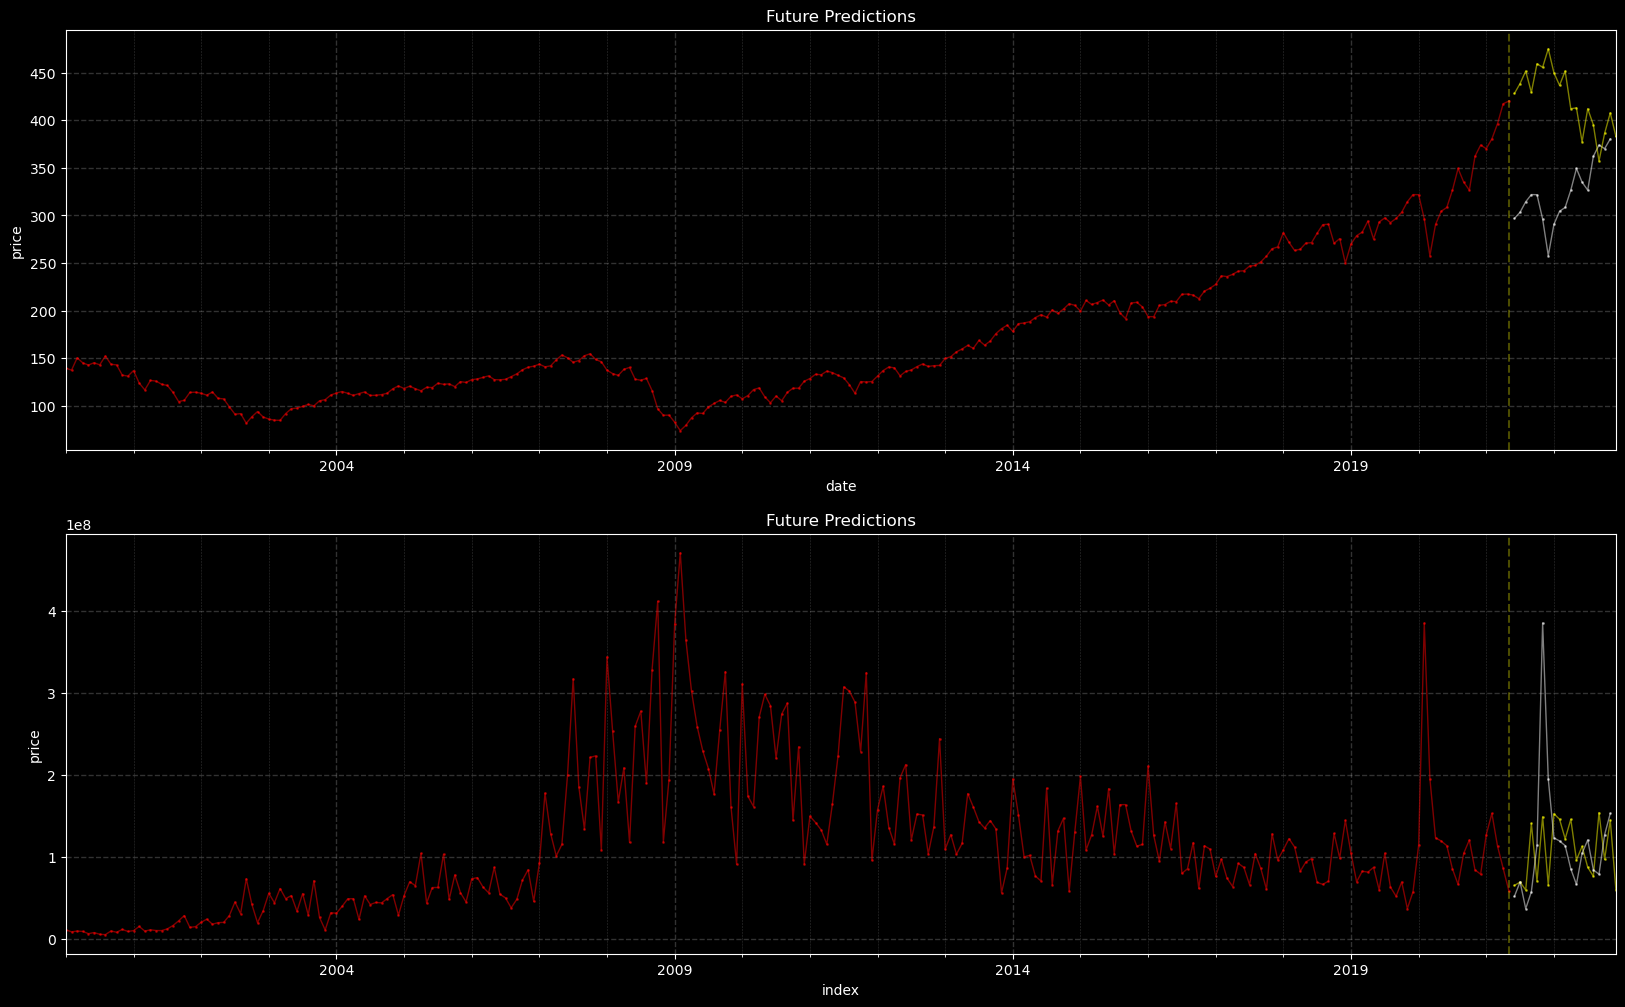

In [244]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, axes = plt.subplots(nrows=2) # fig, axes = plt.subplots(nrows=2, ncols=2)


df["close"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
if not use_entire_data:
    test_df["close"].plot(figsize=(20, 12), # **ACTUALS**
                                   color="yellow",
                                   ms=1,
                                   lw=1,
                                   ax=axes[0],
                                   title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
    test_df["volume"].plot(figsize=(20, 12),
                                   color="yellow",
                                   ms=1,
                                   lw=1,
                                   ax=axes[1],
                                   title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)


df["volume"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_volume"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

axes[0].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[0].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[0].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)


axes[1].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[1].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[1].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()

In [202]:
"""
Model Training w/ Gradient Boosted Regressor
"""
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor

short_name = "gbr"
gbr_seq = GradientBoostingRegressor(random_state=42)
chained_gbr = RegressorChain(gbr_seq)
chained_gbr.fit(X_train, y_train)

"""
Run Forecasts
"""
gbr_seq_preds = chained_gbr.predict(forecast_inputs) # X_test

"""
Store Results
"""
forecast_dict = cat_val_in_arr(gbr_seq_preds[0], TARGET)         
# Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


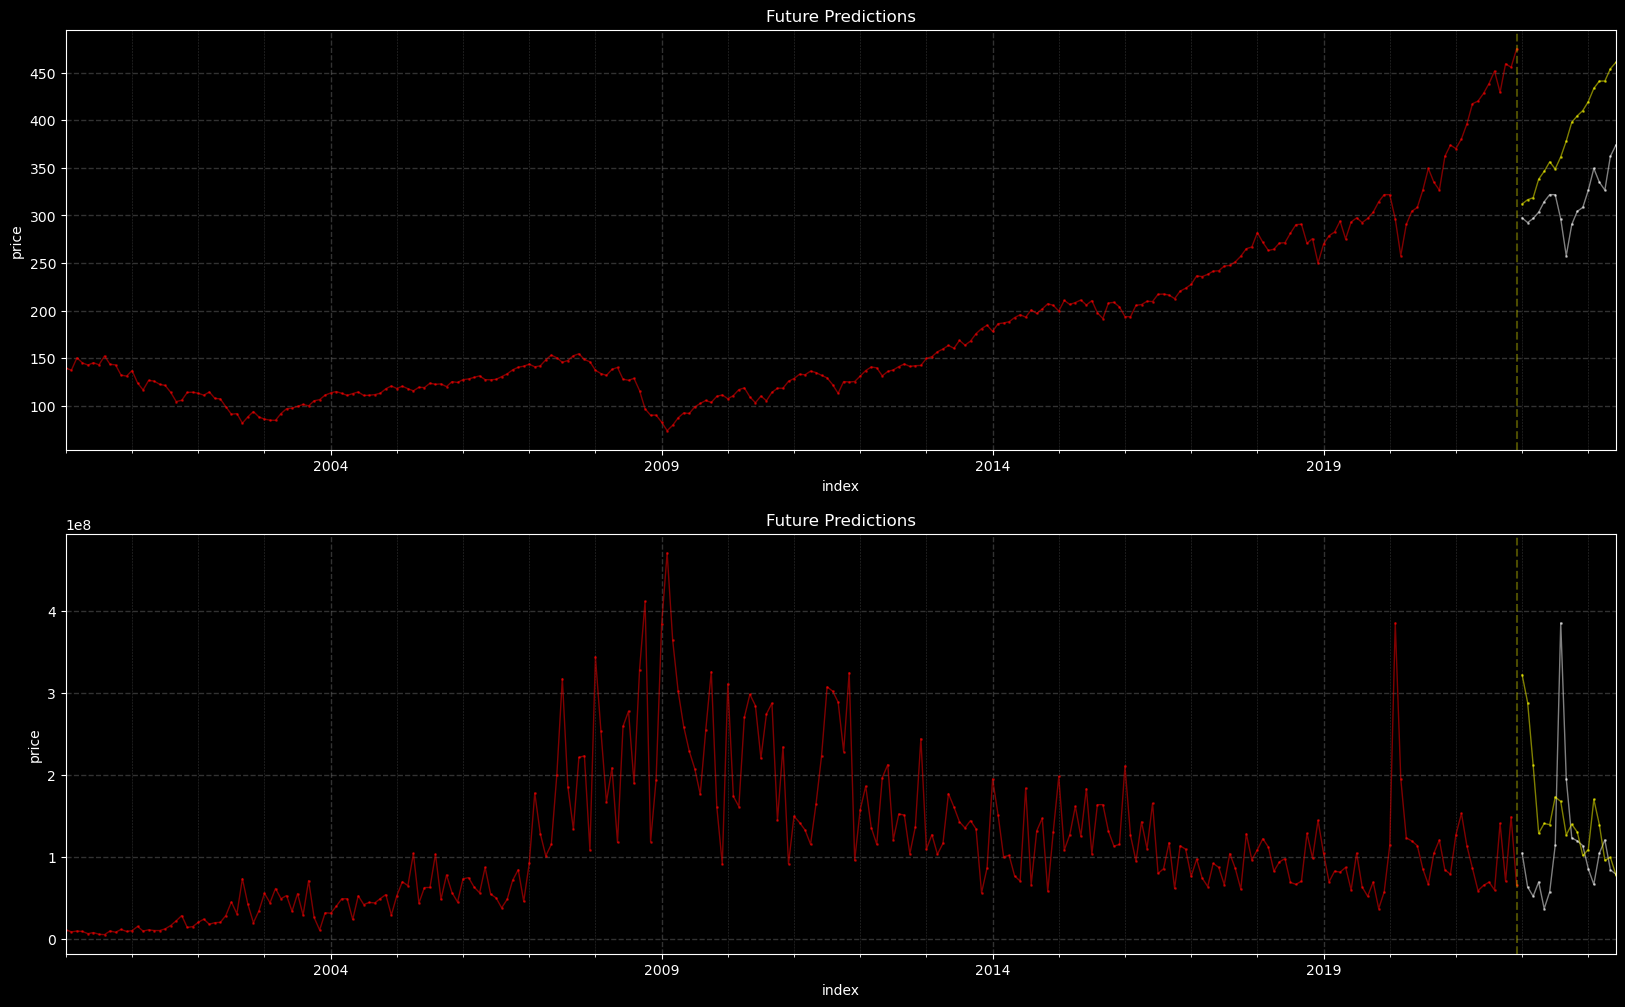

In [203]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, axes = plt.subplots(nrows=2) # fig, axes = plt.subplots(nrows=2, ncols=2)


df["close"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["gbr_pred_close"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)




df["volume"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_volume"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["gbr_pred_volume"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

axes[0].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[0].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[0].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)


axes[1].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[1].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[1].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()

In [204]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

short_name = "svm"
svm_seq = SVR() # can't add random_state = 42??
multioutput_svm_seq = MultiOutputRegressor(svm_seq)
multioutput_svm_seq.fit(X_train, y_train)


"""
Run Forecasts
"""
svm_seq_preds = multioutput_svm_seq.predict(forecast_inputs) # X_test

"""
Store Results
"""

forecast_dict = cat_val_in_arr(svm_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.c

In [205]:
"""
KNN
"""
from sklearn.neighbors import KNeighborsRegressor
short_name = "knn"
knn = KNeighborsRegressor()
multioutput_knn = MultiOutputRegressor(knn) # Look into multiouput regressor. Still get same result without it....

multioutput_knn.fit(X_train,y_train)
knn_seq_preds = multioutput_knn.predict(forecast_inputs)


"""
Store Results
"""

forecast_dict = cat_val_in_arr(knn_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.

In [206]:
"""
Random Forest
"""
from sklearn.ensemble import RandomForestRegressor

short_name = "rf"
param_grid = {'n_estimators': [10, 100, 1000], 'max_depth': [None, 5, 10]}
# Create a grid search object using the hyperparameter grid and the random forest regressor

rf_regressor = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)
# rf_regressor.fit(X_train,y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print(best_params)


# Create a random forest regressor with the best hyperparameters
rf_regressor = RandomForestRegressor(**best_params)
rf_regressor.fit(X_train,y_train)

rf_seq_preds = rf_regressor.predict(forecast_inputs)


"""
Store Results
"""

forecast_dict = cat_val_in_arr(rf_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

{'max_depth': 5, 'n_estimators': 100}


/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [207]:
# help(grid_search)

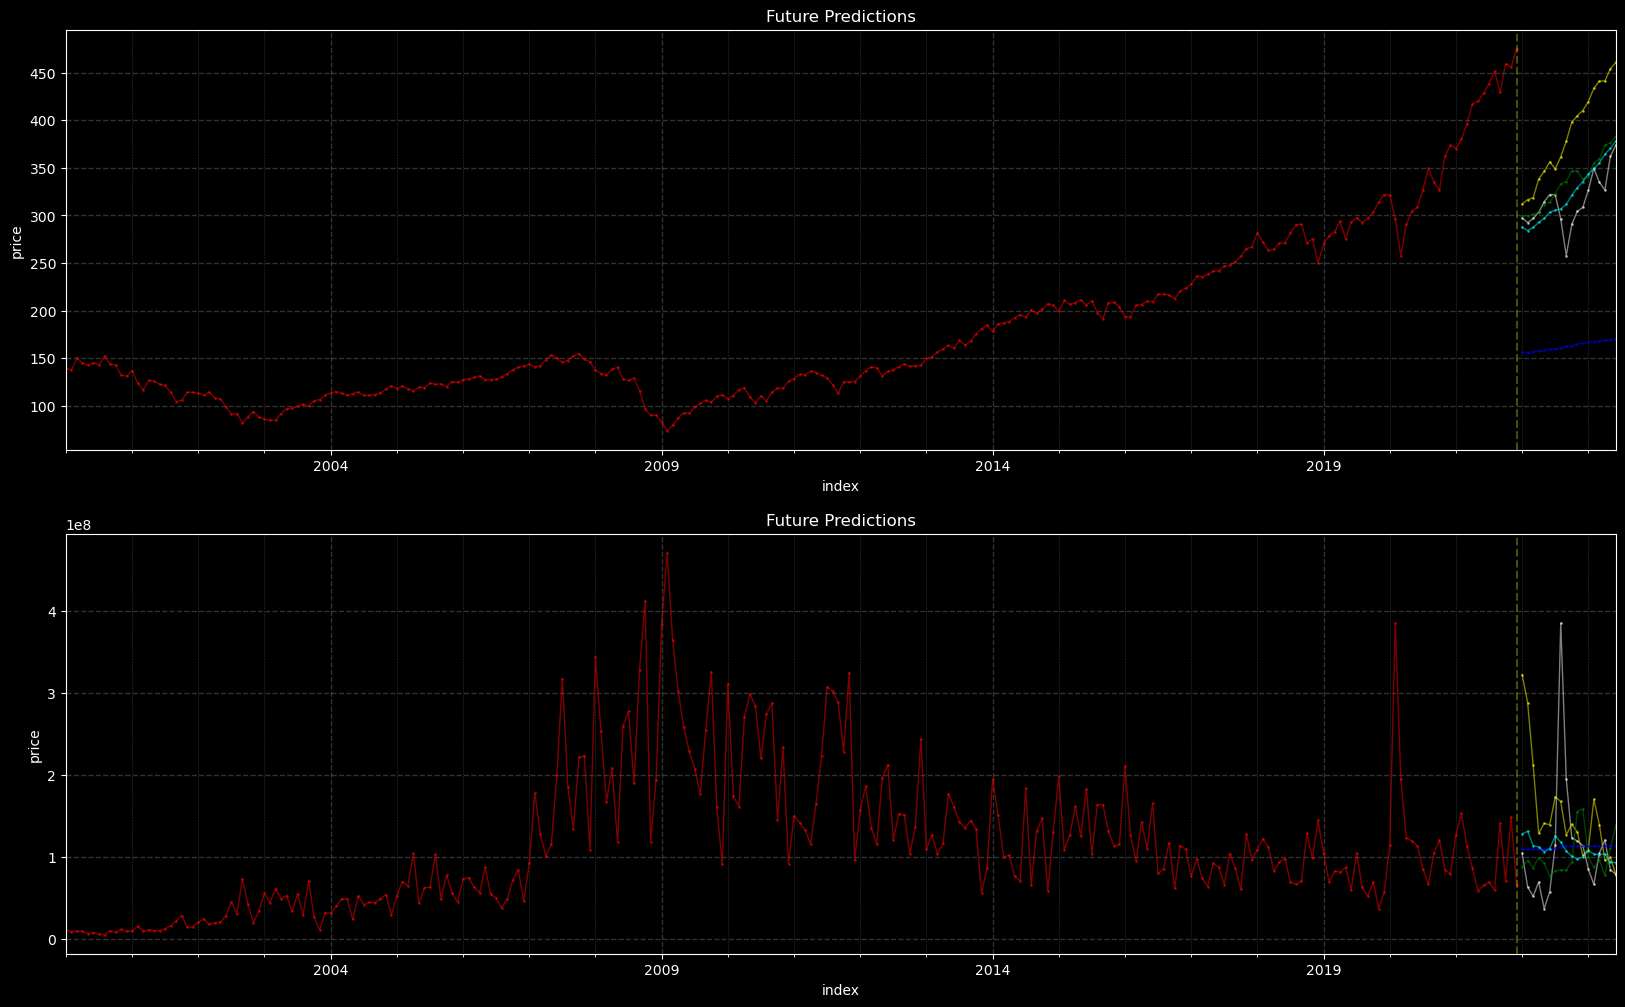

In [208]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, axes = plt.subplots(nrows=2) # fig, axes = plt.subplots(nrows=2, ncols=2)


df["close"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["gbr_pred_close"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["knn_pred_close"].plot(figsize=(20, 12),
                               color="green",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["svm_pred_close"].plot(figsize=(20, 12),
                               color="blue",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["rf_pred_close"].plot(figsize=(20, 12),
                               color="cyan",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)





df["volume"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_volume"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["gbr_pred_volume"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["knn_pred_volume"].plot(figsize=(20, 12),
                               color="green",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["svm_pred_volume"].plot(figsize=(20, 12),
                               color="blue",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["rf_pred_volume"].plot(figsize=(20, 12),
                               color="cyan",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

axes[0].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[0].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[0].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)


axes[1].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[1].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[1].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()

In [209]:
"""
Light Gradient Boost
"""

import lightgbm as lgb



short_name = "lgb"

lgb_regressor = lgb.LGBMRegressor()

multioutput_lgb = MultiOutputRegressor(lgb_regressor) # Look into multiouput regressor. Still get same result without it....

multioutput_lgb.fit(X_train,y_train)

lgb_seq_preds = multioutput_lgb.predict(forecast_inputs)


"""
Store Results
"""

forecast_dict = cat_val_in_arr(lgb_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

In [222]:
"""
XG Boost
TODO: Take a look at why results are so off
"""
short_name = "xgb"
# xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                        n_estimators=1000,
#                        #early_stopping_rounds=50,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.01)

xgb_regressor = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)

xgb_regressor.fit(X_train, y_train,
        verbose=100)

xgb_seq_preds = xgb_regressor.predict(forecast_inputs)

"""
Store Results
"""

forecast_dict = cat_val_in_arr(xgb_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]


In [ ]:
"""
TODO: Add differencing error to forecast_df (loop through all results)

"""
mean_squared_error(forecast_df["dt_pred_close"], forecast_df["actuals_close"])
forecast_df["error"] = abs(forecast_df["actuals_close"] - forecast_df["dt_pred_close"])

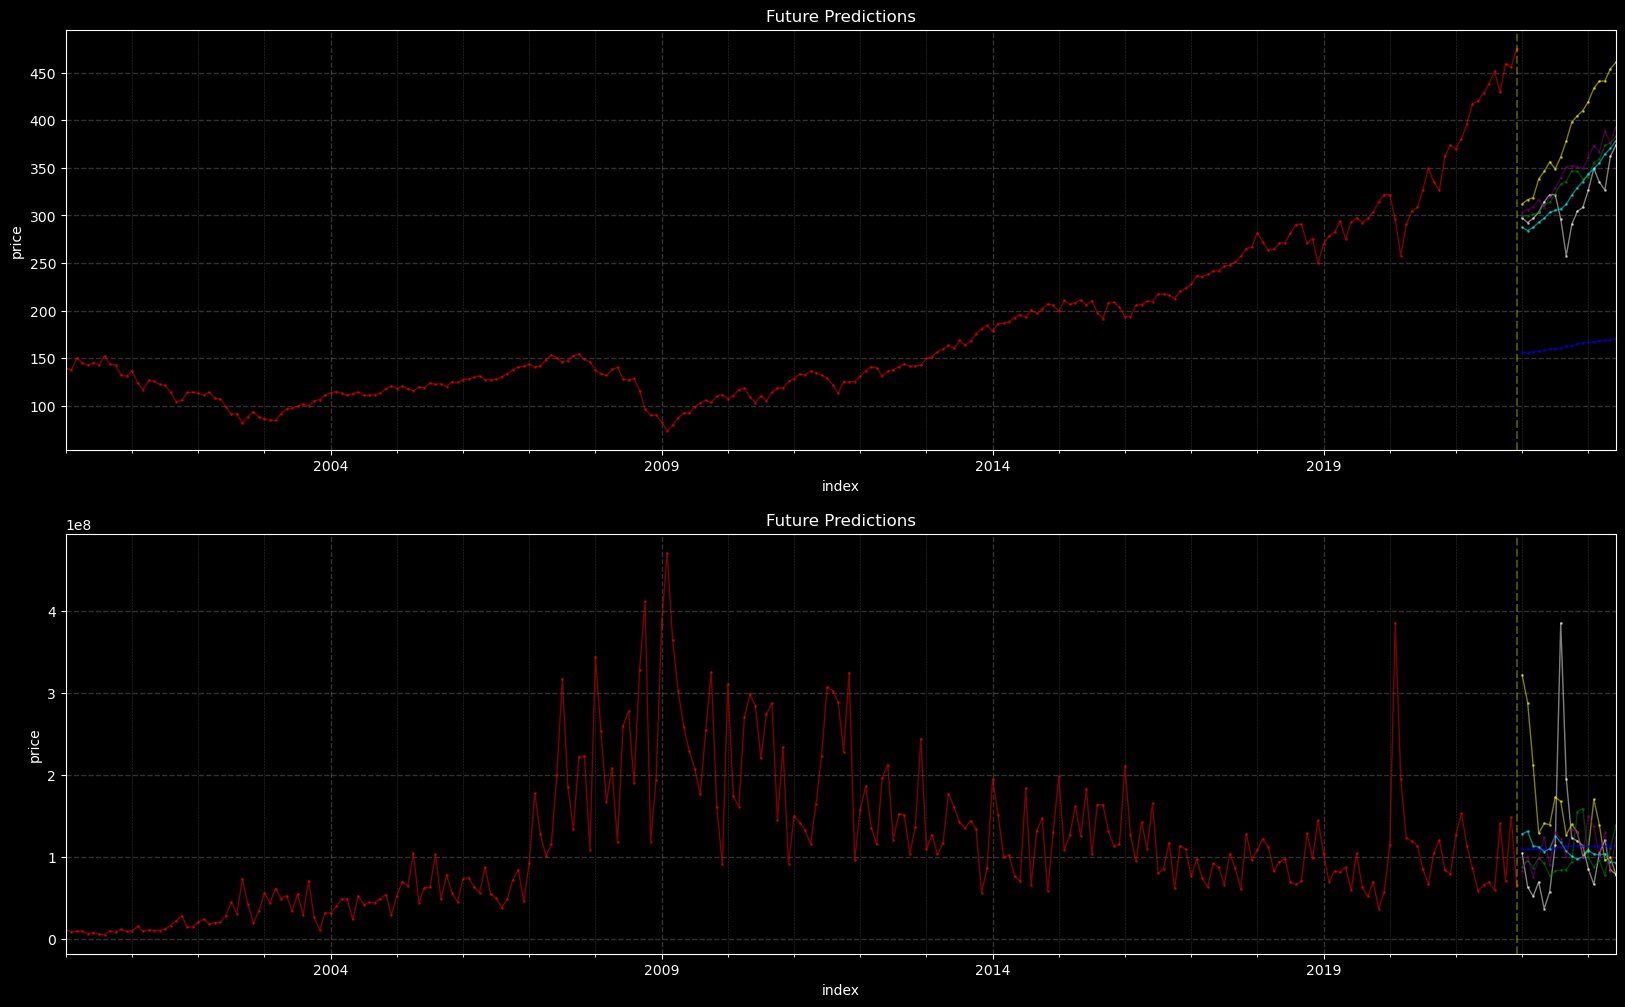

In [225]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, axes = plt.subplots(nrows=2) # fig, axes = plt.subplots(nrows=2, ncols=2)


df["close"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["gbr_pred_close"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["knn_pred_close"].plot(figsize=(20, 12),
                               color="green",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["svm_pred_close"].plot(figsize=(20, 12),
                               color="blue",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["rf_pred_close"].plot(figsize=(20, 12),
                               color="cyan",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["lgb_pred_close"].plot(figsize=(20, 12),
                               color="purple",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
# forecast_df["xgb_pred_close"].plot(figsize=(20, 12),
#                                color="pink",
#                                ms=1,
#                                lw=1,
#                                ax=axes[0],
#                                title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)










df["volume"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_volume"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["gbr_pred_volume"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["knn_pred_volume"].plot(figsize=(20, 12),
                               color="green",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["svm_pred_volume"].plot(figsize=(20, 12),
                               color="blue",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["rf_pred_volume"].plot(figsize=(20, 12),
                               color="cyan",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["lgb_pred_volume"].plot(figsize=(20, 12),
                               color="purple",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
# forecast_df["xgb_pred_volume"].plot(figsize=(20, 12),
#                                color="pink",
#                                ms=1,
#                                lw=1,
#                                ax=axes[0],
#                                title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)




axes[0].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[0].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[0].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)


axes[1].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[1].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[1].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()

## Classic Plotting

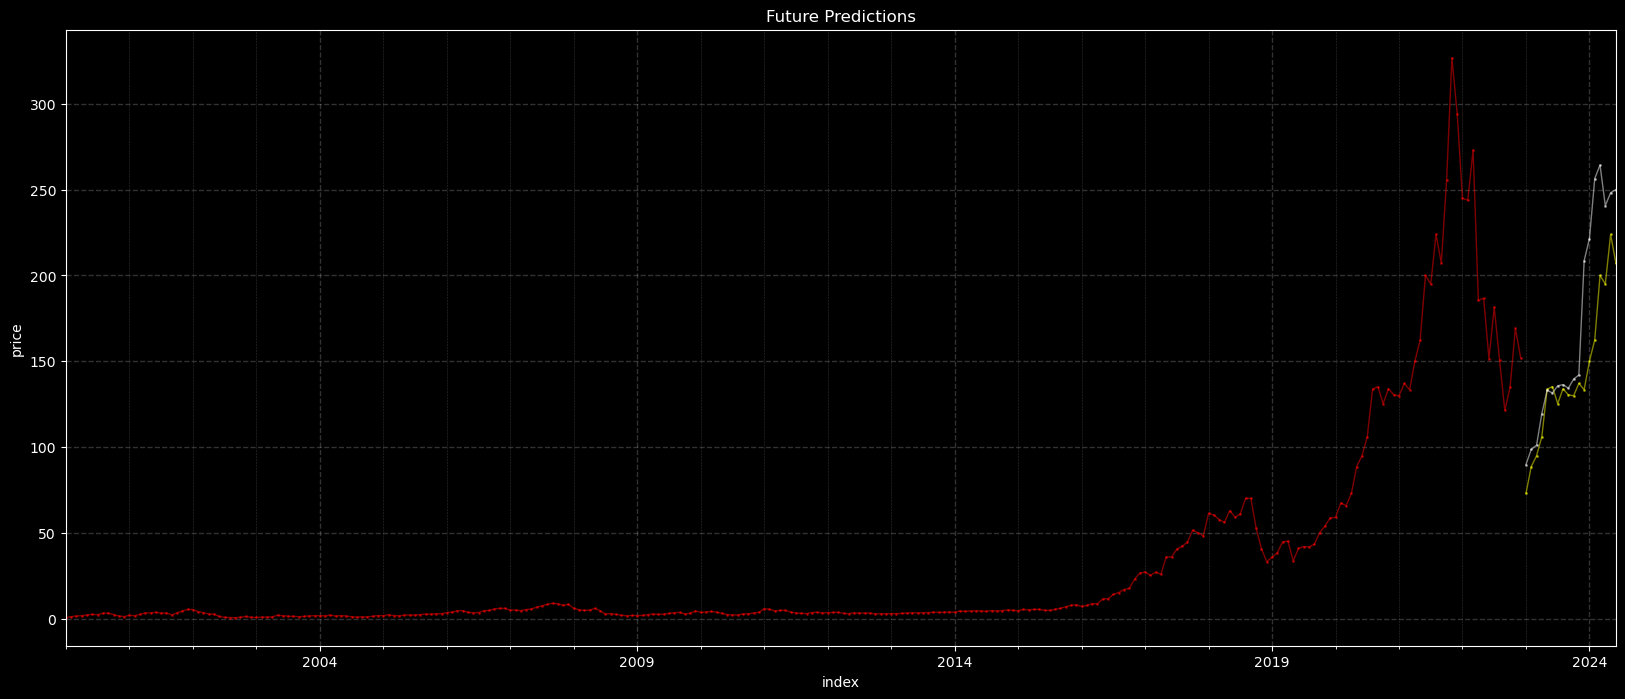

In [22]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, ax = plt.subplots()

df[signal_to_plot].plot(figsize=(20, 8),
                               color="red",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 8),
                               color="yellow",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["gbr_pred_close"].plot(figsize=(20, 8),
                               color="white",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
#ax.axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
ax.grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
ax.grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()